# Non-linear models

The non-linear models are also similar to simulate. We add a non-linear to the equation:

\begin{equation}
\rho \ddot{w} + \left(d_1 + d_3 \Delta\right)\dot{w} + (D \Delta \Delta - T_0 \Delta) w = f_{\text{ext}} - f_{\text{nl}},
\end{equation}

where $f_{\text{nl}}$ is the non-linear term. Again we get damped harmonic oscillators:

\begin{equation}
\ddot{q}_{\mu} + 2\gamma_{\mu}\dot{q}_{\mu} + \omega_{\mu}^2 q_{\mu} = \bar{f}_{\text{ext},\mu} - \bar{f}_{\text{nl},\mu},
\end{equation}

where $\bar{f}_{\text{nl},\mu}$ is the non-linear term in modal space. This term differs depending on the type of non-linearity and whether we are simulating a string, membrane or plate.




## Tension modulated string

For tension-modulated strings the non-linear term expanded in modal coordinates is given by:

\begin{equation}
\bar{f}_{nl} = \tau \sum_{\mu} \frac{\lambda_{\mu} q_{\mu}^2}{||\Phi_{\mu}||^2},
\end{equation}

where $\tau$ is:

\begin{equation}
\tau = \frac{E A}{2 L}
\end{equation}



First, we set up the parameters for the string.

In [ ]:
# | hide

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

from jaxdiffmodal.coupling import compute_coupling_matrix
from jaxdiffmodal.excitations import create_1d_raised_cosine, create_pluck_modal
from jaxdiffmodal.ftm import (
    PlateParameters,
    StringParameters,
    damping_term,
    evaluate_rectangular_eigenfunctions,
    evaluate_string_eigenfunctions,
    inverse_STL,
    plate_eigenfunctions,
    plate_eigenvalues,
    plate_wavenumbers,
    stiffness_term,
    string_eigenfunctions,
    string_eigenvalues,
)
from jaxdiffmodal.time_integrators import (
    make_tm_nl_fn,
    make_vk_nl_fn,
    solve_tf_excitation,
    solve_tf_initial_conditions,
    string_tau_with_density,
)

jax.config.update("jax_enable_x64", True)

In [ ]:
n_modes = 50
n_steps = 44100
sample_rate = 44100
dt = 1.0 / sample_rate
excitation_position = 0.2
readout_position = 0.5
initial_deflection = 0.04
n_gridpoints = 101  # number of gridpoints for evaluating the eigenfunctions
string_params = StringParameters()

Get the eigenpairs and the initial condition

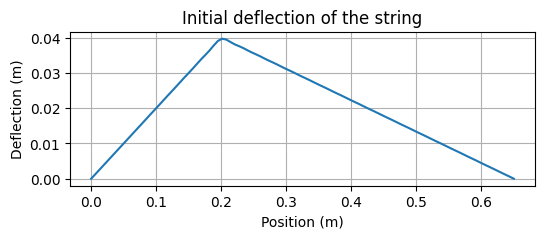

In [ ]:
# | code-fold: true

lambda_mu = string_eigenvalues(n_modes, string_params.length)
wn = np.sqrt(lambda_mu)
grid = np.linspace(0, string_params.length, n_gridpoints)
K = string_eigenfunctions(wn, grid)


u0_modal = create_pluck_modal(
    lambda_mu,
    pluck_position=excitation_position,
    initial_deflection=initial_deflection,
    string_length=string_params.length,
)
u0 = inverse_STL(K, u0_modal, string_params.length)
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(grid, u0)
ax.set_xlabel("Position (m)")
ax.set_ylabel("Deflection (m)")
ax.set_title("Initial deflection of the string")
ax.grid(True)

Define the non-linear term and integrate in time

In [ ]:
# | code-fold: true

gamma2_mu = damping_term(string_params, lambda_mu)
omega_mu_squared = stiffness_term(string_params, lambda_mu)

string_tau = string_tau_with_density(string_params)
string_norm = string_params.length / 2

# include the norm and lambda_mu to make it more compact
string_tau = string_tau * lambda_mu / string_norm

nl_fn = make_tm_nl_fn(lambda_mu, string_tau)
_, modal_sol = solve_tf_initial_conditions(
    gamma2_mu,
    omega_mu_squared,
    u0=u0_modal,
    v0=jnp.zeros_like(u0_modal),
    dt=dt,
    n_steps=n_steps,
    nl_fn=nl_fn,
)

# transpose to have modes in the first dimension
modal_sol = modal_sol.T

print(modal_sol.shape)

(50, 44100)


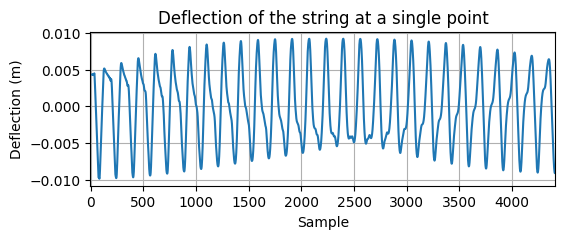

In [ ]:
# | code-fold: true

mu = np.arange(1, n_modes + 1)  # mode indices

readout_weights = evaluate_string_eigenfunctions(
    mu,
    readout_position,
    string_params,
)

# at a single point
u_readout = readout_weights @ modal_sol

# at all points
sol = inverse_STL(K, modal_sol, string_params.length)

display(Audio(u_readout, rate=sample_rate))
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(u_readout)
ax.set_xlabel("Sample")
ax.set_ylabel("Deflection (m)")
ax.set_title("Deflection of the string at a single point")
ax.set_xlim(-2, sample_rate // 10)
ax.grid(True)

## Tension modulated plate

The tension-modulated plate works just like the string we saw earlier, same non-linear term, but with a different $\tau$ value:

$$
\tau = \frac{E h}{2 L_x L_y (1 - \nu^2)}
$$






Define the parameters for the plate

In [ ]:
# | code-fold: true

n_modes_x = 15
n_modes_y = 15
n_modes = n_modes_x * n_modes_y
n_steps = 44100
sample_rate = 44100
dt = 1.0 / sample_rate
excitation_duration = 1.0  # seconds
excitation_amplitude = 40
force_position = (0.05, 0.05)
readout_position = (0.1, 0.1)
plate_params = PlateParameters(
    Ts0=0.0,
    d1=1e-4,
    d3=1e-2,
)

Get the eigenpairs and the excitation

In [ ]:
# | code-fold: true

wnx, wny = plate_wavenumbers(
    n_modes_x,
    n_modes_y,
    plate_params.l1,
    plate_params.l2,
)
lambda_mu_2d = plate_eigenvalues(wnx, wny)
n_gridpoints_x = 101
n_gridpoints_y = 151
x = np.linspace(0, plate_params.l1, n_gridpoints_x)
y = np.linspace(0, plate_params.l2, n_gridpoints_y)
K = plate_eigenfunctions(wnx, wny, x, y)

# Sort the eigenvalues and get the indices
indices = np.argsort(lambda_mu_2d.ravel())
ky_indices, kx_indices = np.unravel_index(indices, lambda_mu_2d.shape)
ky_indices, kx_indices = ky_indices + 1, kx_indices + 1
selected_indices = np.stack([kx_indices, ky_indices], axis=-1)
lambda_mu = np.sort(lambda_mu_2d.reshape(-1))

rc = create_1d_raised_cosine(
    duration=excitation_duration,
    start_time=0.010,
    end_time=0.012,
    amplitude=excitation_amplitude,
    sample_rate=sample_rate,
)

weights_at_ex = (
    evaluate_rectangular_eigenfunctions(
        selected_indices,
        force_position,
        params=plate_params,
    )
    / plate_params.density
)

weights_at_readout = evaluate_rectangular_eigenfunctions(
    selected_indices,
    readout_position,
    params=plate_params,
)

modal_excitation = np.outer(rc, weights_at_ex)

Define the non-linear term and integrate in time

In [ ]:
# | code-fold: true

gamma2_mu = damping_term(
    plate_params,
    lambda_mu,
)
omega_mu_squared = stiffness_term(
    plate_params,
    lambda_mu,
)

plate_tau = (plate_params.E * plate_params.h) / (
    2 * plate_params.l1 * plate_params.l2 * (1 - plate_params.nu**2)
)
plate_tau = plate_tau / plate_params.density
plate_norm = 0.25 * plate_params.l1 * plate_params.l2

plate_tau = plate_tau * lambda_mu / plate_norm

nl_fn = make_tm_nl_fn(lambda_mu, plate_tau)

_, modal_sol = solve_tf_excitation(
    gamma2_mu,
    omega_mu_squared,
    modal_excitation,
    dt,
    nl_fn=nl_fn,
)

modal_sol = modal_sol.T

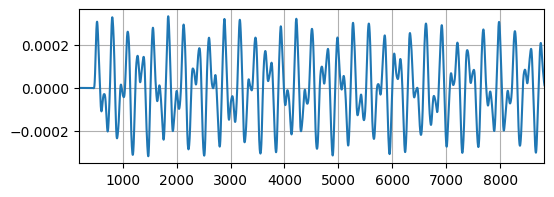

In [ ]:
# | echo: false


sol = weights_at_readout @ modal_sol
sol = sol / plate_norm

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(sol)
ax.grid(True)
ax.set_xlim(200, 4410 * 2)

sol_vel = jnp.diff(sol)
display(Audio(sol_vel, rate=sample_rate))

## Von Karman plate

In the Von Karman plate we have a different non-linear term:

\begin{equation}
\bar{f}_{nl} = \frac{E S_w}{2 \rho} \sum_{p, q, r}^n \frac{H_{q, r}^n C_{p, n}^s}{\zeta_n^4} q_p q_q q_r,
\end{equation}


We will use the same parameters as in the tension-modulated plate above but now we need the coupling coefficients (assuming simply supported boundary conditions). Calculating the coupling coefficients can take a while, so we will only use 10 in-plane modes and all transverse modes. We will also set $S_w = ||\Phi||^2$ and increase the excitation amplitude to make the coupling effect more noticeable

In [ ]:
# | hide

n_psi = 10  # onlt 10 in-plane modes
n_phi = n_modes  # all transverse modes

lambda_mu = plate_eigenvalues(wnx, wny)
indices = np.argsort(lambda_mu.ravel())
ky_indices, kx_indices = np.unravel_index(indices, lambda_mu.shape)
ky_indices, kx_indices = ky_indices + 1, kx_indices + 1
selected_indices = np.stack([kx_indices, ky_indices], axis=-1)
lambda_mu = lambda_mu.reshape(-1).sort()

H0, H1, H2 = compute_coupling_matrix(
    n_psi,
    n_phi,
    plate_params.l1,
    plate_params.l2,
    kx_indices,
    ky_indices,
)

In [ ]:
# | hide
S_w = plate_norm
scale = (plate_params.E * S_w) / (2 * plate_params.density)
H1_scaled = jnp.array(H1 * jnp.sqrt(scale))

amplitude_scaling = 6

Integrate in time. This is fast however with more modes it will take longer. In any case, this will take longer than the tension-modulated plate.

In [ ]:
# | code-fold: true

gamma2_mu = damping_term(
    plate_params,
    lambda_mu,
)
omega_mu_squared = stiffness_term(
    plate_params,
    lambda_mu,
)

nl_fn = make_vk_nl_fn(H1_scaled)

_, modal_sol = solve_tf_excitation(
    gamma2_mu,
    omega_mu_squared,
    modal_excitation * amplitude_scaling,
    dt,
    nl_fn=nl_fn,
)

modal_sol = modal_sol.T

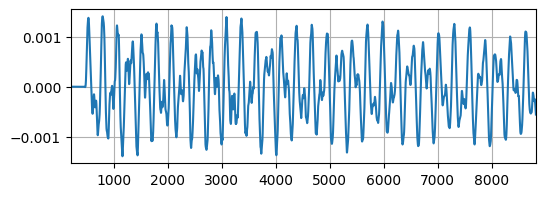

In [ ]:
# | echo: false
sol = weights_at_readout @ modal_sol
sol = sol / plate_norm
sol_vel = jnp.diff(sol)
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(sol)
ax.grid(True)
ax.set_xlim(200, 4410 * 2)

display(Audio(sol_vel, rate=sample_rate))